# Attempt 1

* NaNs replaced by zeros
* Using QuantileTransformer on target
* Using random 80/20 train/test split
* XGBoost on RF using parameters from GridSearch

In [25]:
import numpy as np
import pandas as pd
import matplotlib
import math
from sklearn import model_selection, ensemble, metrics, linear_model, preprocessing
from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
data = pd.read_csv('dataset/undp_train.csv', na_values='nan')

In [49]:
test = pd.read_csv('dataset/undp_test.csv', na_values='nan')

In [134]:
test.tail()

,year,country,Life expectancy Index,Life expectancy at birth,Gross national income (GNI) per capita (2011 PPP$),Income Index,Expected years of schooling (years),Mean years of schooling (years),Human Development Index (HDI),Education Index,...,Mobile phone subscriptions (per 100 people),"Internet users, total (% of population)",Current health expenditure (% of GDP),"Human Development Index (HDI), female","Human Development Index (HDI), male",Gender Development Index (GDI),Adjusted net savings (% of GNI),"HIV prevalence, adult (% ages 15-49), total",Private capital flows (% of GDP),Gender Inequality Index (GII)
885,2016,Yemen,0.709,66.1,1966.0,0.450,8.7,3.0,0.477,0.341,...,60.5,24.6,5.6,0.289,0.550,0.525,NaN,NaN,NaN,0.837
886,2016,Vanuatu,0.770,70.0,2751.0,0.501,11.4,6.7,0.592,0.540,...,78.5,24.0,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,2016,Uruguay,0.885,77.5,19196.0,0.794,16.3,8.7,0.806,0.745,...,149.4,66.4,9.1,0.805,0.793,1.016,10.4,0.6,6.0,0.286
888,2016,Viet Nam,0.849,75.2,5638.0,0.609,12.7,8.1,0.685,0.621,...,128.8,53.0,5.7,0.686,0.683,1.005,13.9,0.4,-5.8,0.323
889,2016,Zimbabwe,0.620,60.3,2246.0,0.470,10.4,8.3,0.549,0.567,...,91.8,23.1,9.4,0.526,0.570,0.923,-19.3,13.7,-1.3,0.535


In [32]:
data = data.set_index(['year', 'country'])
test = test.set_index(['year', 'country'])

In [39]:
full = data.append(test)

In [44]:
full.to_csv('dataset/full.csv', na_rep='nan')

In [45]:
full = pd.read_csv('dataset/full.csv', na_values='nan')

In [121]:
# FOR ONE HOT ENCODING
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection

X_train = data.iloc[:, 0:-1].values
X_test = test.values
y_train = data.iloc[:, -1].values

# imputing missing values
# simple imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputer.fit(full.drop(columns='y').values)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# OneHotEncoder
enc = OneHotEncoder(sparse=False)
print(full.drop(columns='y').values[:, 1].reshape(-1,1).shape)
print(enc.fit_transform(full.drop(columns='y').values[:, 1].reshape(-1,1)).shape)
enc.fit(full.drop(columns='y').values[:, 1].reshape(-1,1))

X_train = np.hstack((X_train, enc.transform(X_train[:, 1].reshape(-1, 1))))
X_test = np.hstack((X_test, enc.transform(X_test[:, 1].reshape(-1, 1))))

X_train = np.delete(X_train, 1, 1)
X_test = np.delete(X_test, 1, 1)

#normalize
scaler = preprocessing.StandardScaler()
scaler.fit(np.vstack((X_train, X_test))[:, :75])
X_train[:, :75] = scaler.transform(X_train[:, :75])
X_test[:, :75] = scaler.transform(X_test[:, :75])


(4755, 1)
(4755, 181)


In [112]:
X_train

array([[-1.6648662794686289, -1.6286122400949699, -1.5328676423145136,
        ..., 0.0, 0.0, 0.0],
       [-1.6648662794686289, 0.43868823576559063, 0.42434454695251783,
        ..., 0.0, 0.0, 0.0],
       [-1.6648662794686289, -0.03115278147544622, -0.021717765950200155,
        ..., 0.0, 0.0, 0.0],
       ...,
       [1.6093119783454835, 0.35724912611047754, 0.34241473437854986,
        ..., 0.0, 0.0, 0.0],
       [1.6093119783454835, 0.5138627985241565, 0.4971710470182676, ...,
        0.0, 0.0, 0.0],
       [1.6093119783454835, -0.5323165331992181, -0.49509001637757544,
        ..., 0.0, 1.0, 0.0]], dtype=object)

In [69]:
X_train.shape

(3865, 256)

In [125]:
#XGBoost
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
import xgboost as xgb
XGB = xgb.XGBRegressor(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1500,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=3,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=0.3,
    reg_alpha=0,
    reg_lambda=0.11,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
    seed=None,
    missing=None,
    importance_type='gain')
XGB.fit(X_train, y_train)

print(MSE(y_train, XGB.predict(X_train))**0.5)

0.0009004150232622033


In [126]:
cvs = -CVS(XGB, X_train,y_train, scoring='neg_root_mean_squared_error', cv=5)
print(cvs.mean(), 'CV score 5-fold of XGB on train')

0.013128146347445375 CV score 5-fold of XGB on train


In [127]:
cvs

array([0.01154904, 0.00515771, 0.00531948, 0.00747433, 0.03614017])

In [142]:
y_pred = XGB.predict(X_test)

# Part 2

In [145]:
raw_test = pd.read_csv('dataset/test.csv')

In [147]:
#alpha is the coefficient before each E_i in calculating
#the likely index increase \Delta y_i multiplied by 1000
def P(y):
    return -np.log(y + 0.01) + 3
def alpha(y):
    return P(y)**2
p2slice = raw_test.iloc[:, 2:3]
p2slice['y pred'] = pd.Series(y_pred)
p2slice['alpha'] = pd.Series([alpha(x) for x in p2slice['y pred']])

In [148]:
p2slice

,existence expectancy index,y pred,alpha
0,0.456086,0.040783,35.762705
1,0.529835,0.038954,36.202726
2,0.560976,0.038881,36.220771
3,0.565910,0.039570,36.052394
4,0.588274,0.021967,41.512875
...,...,...,...
885,NaN,0.021534,41.688968
886,NaN,0.029529,38.821832
887,NaN,0.082569,28.942210
888,NaN,0.053718,33.100384


In [149]:
p2slice[p2slice['existence expectancy index'] < 0.7]

,existence expectancy index,y pred,alpha
0,0.456086,0.040783,35.762705
1,0.529835,0.038954,36.202726
2,0.560976,0.038881,36.220771
3,0.565910,0.039570,36.052394
4,0.588274,0.021967,41.512875
...,...,...,...
61,0.686832,0.044358,34.953700
62,0.688025,0.029303,38.893435
63,0.692317,0.036504,36.823272
64,0.698337,0.027632,39.437052


In [150]:
#indices of 50 largest by alpha points that have EEI < 0.7
k = p2slice[p2slice['existence expectancy index']<0.7]['alpha'].nlargest(50).index.sort_values()
print (k)

#indices of 450 largest by alpha points after dropping the necessary 50 with EEI <0.7
a = p2slice.drop(k)['alpha'].nlargest(450).index.sort_values()
print(a)

k = np.array(k)
a = np.array(a)
ka = np.concatenate([k,a])
print(ka)

Int64Index([ 1,  2,  3,  4,  5,  6,  9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 25, 26, 27, 29, 30, 31, 34, 35, 37, 38, 39, 40, 41, 45, 46,
            47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65],
           dtype='int64')
Int64Index([  0,   7,   8,  12,  13,  24,  28,  32,  36,  42,
            ...
            784, 785, 790, 816, 838, 844, 885, 886, 888, 889],
           dtype='int64', length=450)
[  1   2   3   4   5   6   9  10  11  14  15  16  17  18  19  20  21  22
  23  25  26  27  29  30  31  34  35  37  38  39  40  41  45  46  47  48
  49  50  52  53  54  55  56  57  58  60  62  63  64  65   0   7   8  12
  13  24  28  32  36  42  43  51  59  61  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 13

In [168]:
answer = pd.DataFrame(data={'index': raw_test.index,
                  'pred': y_pred,
                  'opt_pred': 0})
for i in ka:
    answer.iloc[i, 2] = 100

In [169]:
answer['opt_pred'].sum()

50000

In [170]:
answer[p2slice['existence expectancy index']<0.7]['opt_pred'].sum()

6400

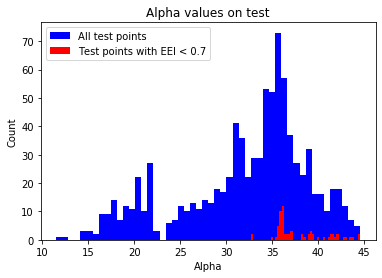

In [171]:
plt.hist(p2slice['alpha'], label='All test points', color='b', bins=50)
plt.hist(p2slice.iloc[:66, -1],
         label ='Test points with EEI < 0.7', color='r', bins=50)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Count')
plt.title('Alpha values on test')
plt.show()

In [172]:
answer = answer.set_index(['index'])

In [173]:
answer.to_csv('answer1.csv')